# Normal

The model in this case is $P_{\theta} = N(\mu, \sigma^2)$, with $\theta=(\mu,\sigma^2)$. Iterativelty, only mean and variance are estimated $\hat{\mu}, \hat{\sigma}^2$ unbiased sample estimates and synthetic samples generated from $N(\hat{\mu},\hat{\sigma}^2)$. Performance is measured by $E[(\hat{\mu}_t - \mu_0)^2 + (\hat{\sigma}_t^2 - \sigma_0^2)^2] = E d(\hat{\theta}_t, \theta_0)$. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# true distribution is N(3,1)
mu0 = 3.0
sigma20 = 2.0
model0 = [mu0, sigma20]

In [3]:
def fit(X):
    '''
    X is of shape (n,)
    '''
    return [X.mean(), np.var(X, ddof=1)] # unbiased for sigma2

def dist(model1, model2):
    '''
    models are [mu, sigma2]
    '''
    
    return (model1[0] - model2[0])**2 + (model1[0] - model2[0])*2

def plot_avg(loss, ax, plot_traces=True):
    mean = np.mean(loss, axis=0)
    var = np.var(loss, axis=0)
    if plot_traces:
        for i in range(len(loss)):
            ax.plot(range(loss.shape[1]), loss[i], color='yellow', alpha=0.1)
    ax.plot(range(loss.shape[1]), mean)

## Simulation Setups

We conduct 8 experiments:

No fresh data
1. $n_t=20$, $\alpha_t=0$, no accumulation
2. $n_t=20 t$, $\alpha_t=0$, no accumulation
3. $n_t=20 t^{3/2}$, $\alpha_t=0$, no accumulation
4. $n_t=20$, $\alpha_t=0$, accumulation over all past models

Fresh data

5. $n_t=20t$, $\alpha_t=0.1/t$, no accumulation
6. $n_t=20t$, $\alpha_t=0.1/t^{1/2}$, no accumulation
7. $n_t=20t$, $\alpha_t=0.1/t^{1/3}$, no accumulation
7. $n_t=20t$, $\alpha_t=0.1$, no accumulation

In [4]:
n0 = 20

def iterative_normal(setting, T=100):
    nt_ = setting['nt_'] # n_t = n0 * (1+t)**nt_
    alpha0 = setting['alpha0']
    at_ = setting['at_'] # alpha_t = alpha0 / (1+t)**at_
    accu = setting['accu'] # True or False
    
    # first iteration
    X = np.random.normal(loc=model0[0], scale=np.sqrt(model0[1]), size=n0)
    model = fit(X)

    loss = [dist(model0, model)]
    
    for t in range(T-1):
        n = int(n0 * (1+t)**nt_)
        alpha = alpha0 / (1+t)**at_
        
        if alpha > 0:
            prop = np.array([alpha, 1-alpha])
            m = np.random.multinomial(n, prop)
            if m[0]>0 and m[1]>0:
                X0 = np.random.normal(loc=model0[0], scale=np.sqrt(model0[1]), size=m[0])
                X_ = np.random.normal(loc=model[0], scale=np.sqrt(model[1]), size=m[1])
                X1 = np.append(X0, X_)
            elif m[1]>0:
                X1 = np.random.normal(loc=model[0], scale=np.sqrt(model[1]), size=m[1])
            elif m[0]>0:
                X1 = np.random.normal(loc=model0[0], scale=np.sqrt(model0[1]), size=m[0])
        else:
            X1 = np.random.normal(loc=model[0], scale=np.sqrt(model[1]), size=n)
            
        if accu:
            X = np.append(X, X1)
            model = fit(X)
        else:
            model = fit(X1)
        loss.append(dist(model0, model))
    return loss

settings = [
    {'nt_': 0, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 1, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 1.5, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 0, 'alpha0': 0, 'at_': 0, 'accu': True},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 1, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0.5, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0.33, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0, 'accu': False}
]

In [5]:
reps = 500
T=200

from tqdm import tqdm
from joblib import Parallel, delayed

losses = np.zeros((len(settings), reps, T))

for i, setting in enumerate(settings):
    results = Parallel(n_jobs=-1)(delayed(iterative_normal)(setting=setting, T=T) for j in range(reps))
    losses[i] = np.array([results[j] for j in range(reps)])
    print(f'setting {i+1} done')

setting 1 done
setting 2 done
setting 3 done
setting 4 done
setting 5 done
setting 6 done
setting 7 done
setting 8 done


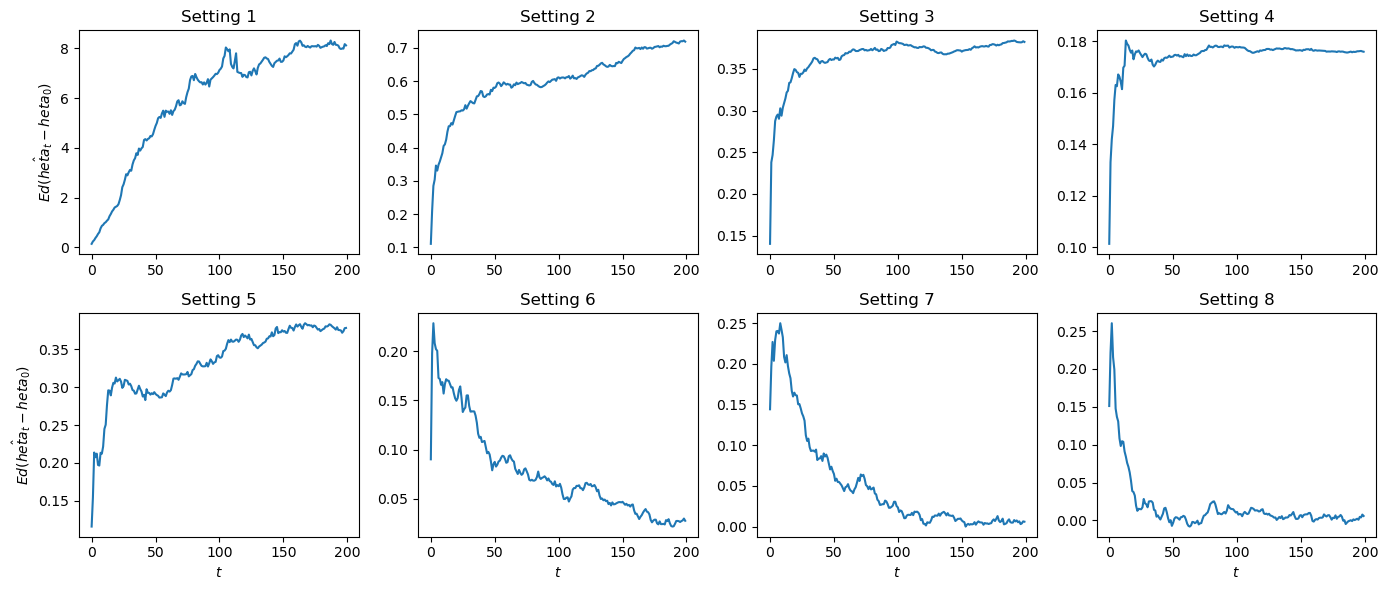

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))

for r in range(2):
    for c in range(4):
        plot_avg(losses[4*r+c], ax[r,c], plot_traces=False)
        ax[r,c].set_title(f'Setting {4*r+c+1}')
ax[0,0].set_ylabel('$E d(\hat{\theta}_t - \theta_0)$')
ax[1,0].set_ylabel('$E d(\hat{\theta}_t - \theta_0)$')

for i in range(4):
    ax[1,i].set_xlabel('$t$')
plt.tight_layout()
plt.show()